# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import edhec_risk_kit as erk

# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# risky assets
risky_r = ind_return.loc["2000":, ["steel", "fin", "beer"]]

# safe asset
# reindex_like will give us a DF with the same shape
safe_r = pd.DataFrame().reindex_like(risky_r)

### CPPI Algorithm

1. Cushion: (Asset Value - Floor value)
2. Compute an allocation to the safe and risky assets -> m*risk_budget
3. Recompute the asset value based on the returns

In [26]:
safe_r[:] = 0.03/12
start = 1000
floor = 0.8
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1) # constraint to keep below 100% (no leverage)
    risky_w = np.maximum(risky_w, 0) # constraint to keep above 0% (no shorting)
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    
    # Update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + (safe_alloc*(1+safe_r.iloc[step]))
    
    # Save the values to keep a history and plot it
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

In [27]:
account_history.head()

,steel,fin,beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [28]:
risky_wealth = start*(1+risky_r).cumprod() # what woudl've happened without any of the CPPI stuff

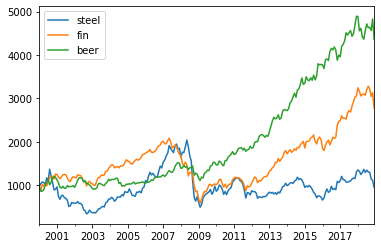

In [29]:
risky_wealth.plot()

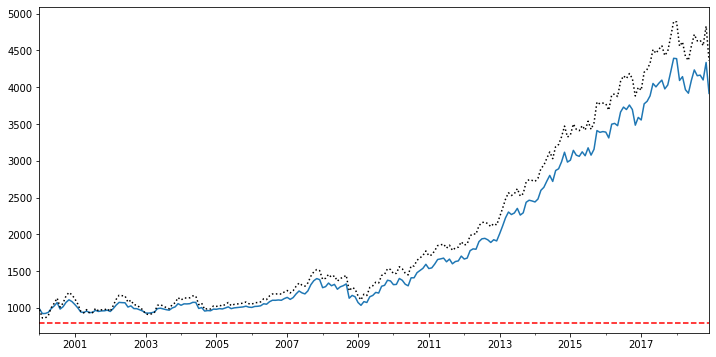

In [30]:
ax = account_history["beer"].plot(figsize=(12,6))
risky_wealth["beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

Beer is much more volatile than investing in the blue asset which is some dynamic mix of beer and the safe asset.

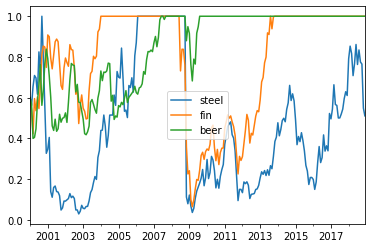

In [31]:
risky_w_history.plot()

This weights vary a lot. The correlation between beer and the safe asset is large. We can see that at some point everything is allocated to beer. Thats why the two lines behave so similar.

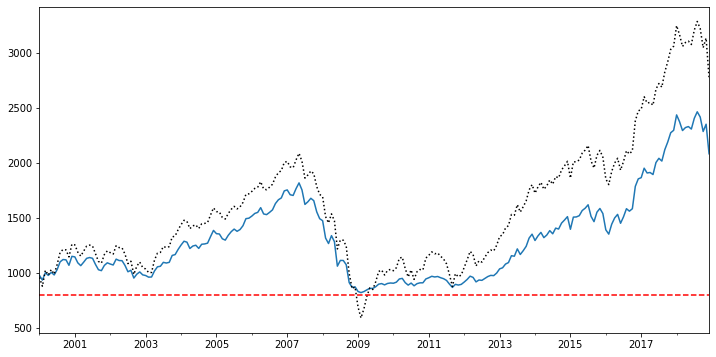

In [32]:
ind = "fin"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

CPPI was much more effective in this case. The blue line bounced off the floor. The disadvantage is that when it bounces back you only have a small exposure to that portfolio and as a result we don't enjoy all the upside.

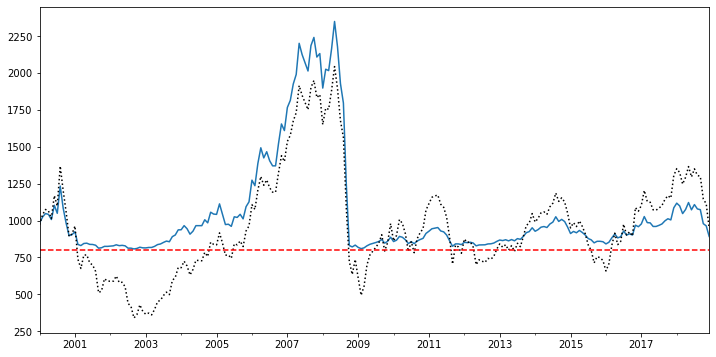

In [33]:
ind = "steel"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

In [36]:
erk.summary_stats(risky_r)

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [41]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["wealth"].pct_change().dropna())

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


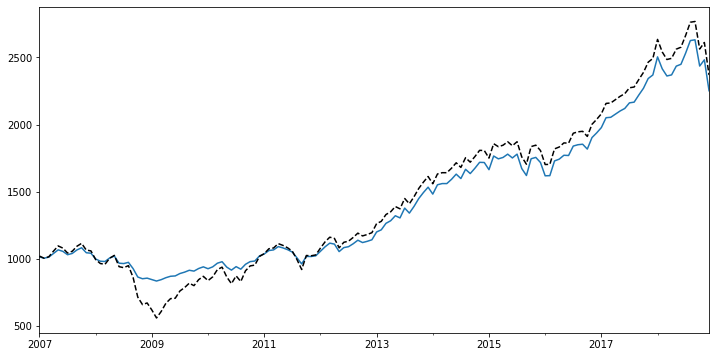

In [42]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["wealth"].plot(figsize=(12,6), legend=False)
btr["risky wealth"].plot(ax=ax, style="k--", legend=False)

In [43]:
erk.summary_stats(btr["risky wealth"].pct_change().dropna())

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [44]:
erk.summary_stats(btr["wealth"].pct_change().dropna())

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


## Drawdown Constraint 

In [45]:
btr = erk.run_cppi(ind_return.loc["2007":, ["steel","fin","beer"]], drawdown=0.25)

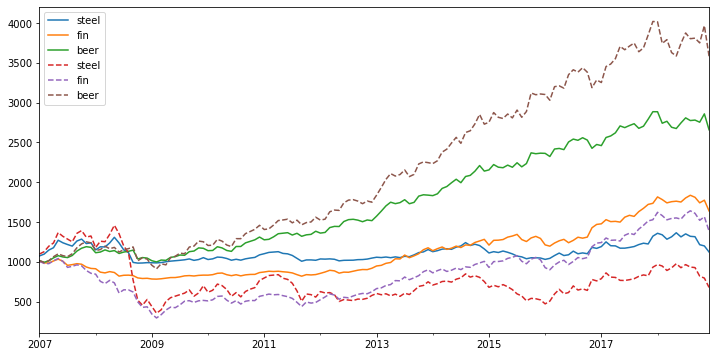

In [46]:
ax = btr["wealth"].plot(figsize=(12,6))
btr["risky wealth"].plot(ax=ax, style="--")

In [47]:
erk.summary_stats(btr["risky wealth"].pct_change().dropna())

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [48]:
erk.summary_stats(btr["wealth"].pct_change().dropna())

,annualized return,annualized vol,skewness,kurtosis,Cornish-Fisher VaR (5%),historic CVaR (5%),sharpe ratio,max drawdown
steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
